# 1. Simple look at data

In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
import numpy as np
import os

In [2]:
raw_data = pd.read_csv(os.getcwd() + "\\input\\data.csv", index_col=0)
raw_data.describe()

,user_id,movie_id,rating,timestamp
count,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,500.112340,2499.322840,2.996310,1.599995e+09
std,288.705961,1445.901876,1.412705,5.762080e+07
min,1.000000,1.000000,1.000000,1.500001e+09
25%,248.000000,1253.000000,2.000000,1.550361e+09
50%,500.000000,2499.000000,3.000000,1.599895e+09
75%,751.000000,3750.000000,4.000000,1.649746e+09
max,1000.000000,5000.000000,5.000000,1.699999e+09


In [218]:
# check duplicate - if user rate the movie twice
unique_combination = raw_data[['user_id','movie_id']].drop_duplicates().shape[0]
all_combination = raw_data[['user_id','movie_id']].shape[0]

if unique_combination != all_combination:
    print("There are duplicates ! If user rateded one film by [r1,..,rn] then final rating is max([r1,..,rn])")
    # get the higest rating
    raw_data = raw_data[['user_id','movie_id','rating']].groupby(by=['user_id','movie_id']).max()
    raw_data = raw_data.reset_index(drop=False)

# TO DO

In [204]:
print("Number of unique users: ", len(raw_data.user_id.unique()))
print("Number of unique movies: ", len(raw_data.movie_id.unique()))
print("Rating scale: ", np.sort(raw_data.rating.unique()))

Number of unique users:  1000
Number of unique movies:  5000
Rating scale:  [1 2 3 4 5]


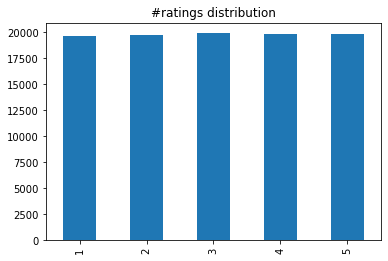

In [205]:
# distribution over ratings
data = raw_data['rating'].value_counts().sort_index(ascending=True)
data.plot(kind='bar',
          title = '#ratings distribution')

***All ratings are proxy uniformy distributed over scale 1-5.***

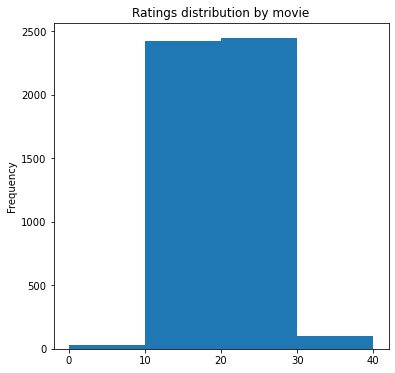

In [206]:
data = raw_data.groupby('movie_id')['rating'].count()
max = np.max(data.values)
bin = np.arange((max)/10+1)*10
data.plot(kind='hist',
          bins = bin,
          figsize = (6,6),
          xticks =bin,
          title = 'Ratings distribution by movie')

***Most of movies is rated x-times where x is from [10,30] interval. Almost all movies are rated at least by ten users.***

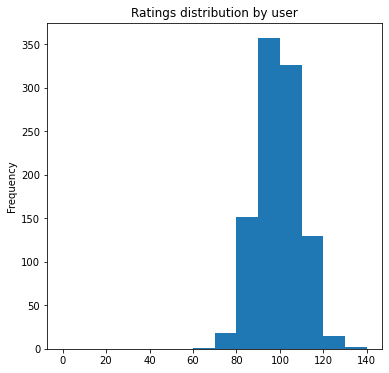

In [207]:
data = raw_data.groupby('user_id')['rating'].count()
max = np.max(data.values)
bin = np.arange((max)/10+1)*10

data.plot(kind='hist',
          bins = bin,
          figsize = (6,6),
          title = 'Ratings distribution by user',)

***Most of users rated at least 80 movies.***

In [181]:
# check duplicate - if user rate the movie twice
unique_combination = raw_data[['user_id','movie_id']].drop_duplicates().shape[0]
all_combination = raw_data[['user_id','movie_id']].shape[0]

if unique_combination != all_combination:
    print("There are duplicates !")

There are duploicates !


# 2. Testing Recommendation model

***The collabolative filtering algorithm has been implemented with slightly modification. Instead of selecting K-similar users to predict the rating, it selects all users with positive cosine similarity, estimated from normalized user-item matrix. It is due to optimization and simplicity of the code.***

***The following section tests prediction of non rated films, based on other similar users rating. If rating prediction is satisfying, then selecting top rated predictions, not previously rated, is considered as resoable recommendations***


***source: https://www.youtube.com/watch?v=h9gpufJFF-0&t=732s***

In [209]:
from module.recommendation_system import RecommendationSystem 

***Load data and split into train, test sets:***

In [210]:
#disable warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# load data
raw_data = pd.read_csv(os.getcwd() + "\\input\\data.csv", index_col=0)

# create a train and test sets:
msk = np.random.rand(len(raw_data)) < 0.9
train = raw_data[msk]
test = raw_data[~msk]

# save train  for loading in our recommender system
train.to_csv(os.getcwd() + "\\input\\data_train.csv")

***Run recommendation system on train set:***

In [211]:
# run the model on the train set
from module.recommendation_system import RecommendationSystem 


model = RecommendationSystem()
model.load_data('data_train')
model.user_item()
model.norm_user_item()
model.user_user_sim()
model.predict_missing_ratings()


Loading input file ....  data_train


***Validate predictions. Firstly, ensure if pivots on train data is the same as orginal pivot 1000 users x 5000 movies***

In [212]:
print(model.user_item_predicted.shape)

(1000, 5000)


***Then compare DIFF(predicted ratings, ratings) from train dataset. There are a lof of different metrics but looking only on  differences between ratings is more intuitive in our case***

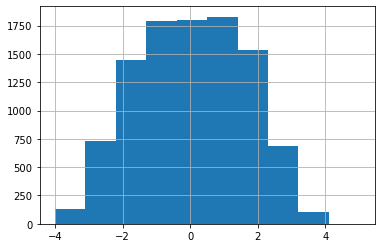

In [213]:
def f(user,movie):

    # users id are from 1 to 1000, indexes from 0 to 999
    # movies id are from 1 to 5000, indexes are from 0 to 4999
    
    return model.user_item_predicted[int(user)-1,int(movie) -1]

test['rating_predicted'] = test.apply(lambda x: f(x.user_id, x.movie_id), axis=1)
test['diff'] = test['rating'] - test['rating_predicted']
# plot abs differences
test['diff'].hist()

In [214]:
test[['diff']].describe()

,diff
count,10051.000000
mean,0.045175
std,1.593358
min,-4.000000
25%,-1.186330
50%,0.039949
75%,1.295830
max,5.000000


***Results are not perfect. Residuals are closely normally distributed with mean around 0 and std 1.6.
For 50% of out test datapoints, predicted rating vs actiual rating differs within range [-1.18,1.29], which is quite satisfying.***

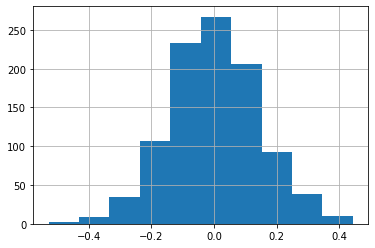

In [215]:
averages_pd = pd.DataFrame({"raw average" : model.average_user_rating, "predicted average" : np.mean(model.user_item_predicted,axis=1)})
averages_pd['diff'] = averages_pd['raw average'] - averages_pd['predicted average']
# plot abs differences
averages_pd['diff'].hist()

***The avergare "taste' of the user, so avergare rating of the movie is quite comparable with the predicted average***